<a href="https://colab.research.google.com/github/oklaja/Virtual-Drug-Screening-for-Covid-19/blob/main/Virtual_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies
!pip install rdkit-pypi
import torch
print(torch.__version__)
!pip install torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch_geometric
import re
from rdkit import Chem
from torch_geometric.data import (InMemoryDataset, Data)
import sys
import re

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 52.1 MB/s 
1.11.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 7.9 MB 6.5 MB/s 
     |████████████████████████████████| 3.5 MB 32.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 407 kB 5.4 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=260330c68dbebdd3f3c3efb47d06f6f16dedb6e604b2a1984dc7a1c7bc522e9c
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
# Mount your google drive with trained models
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the model
epoch = 131
save_PATH = f"/content/drive/MyDrive/AI/covid-1/model250/covid-250-l4-t3--1-epoch{epoch:03d}model1.pt"
model = torch.load(save_PATH, map_location=torch.device('cpu'))

In [ ]:
# Processing of SMILES, generating features

class GenFeatures(object):
    def __init__(self):
        self.symbols = [
            'B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 'As', 'Se', 'Br',
            'Te', 'I', 'At', 'H', 'Na', 'K', 'Al', 'other'
        ]
 
        self.hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            'other',
        ]
 
        self.stereos = [
            Chem.rdchem.BondStereo.STEREONONE,
            Chem.rdchem.BondStereo.STEREOANY,
            Chem.rdchem.BondStereo.STEREOZ,
            Chem.rdchem.BondStereo.STEREOE,
        ]
 
    def __call__(self, data):
        # Generate AttentiveFP features according to Table 1.
        mol = Chem.MolFromSmiles(data.smiles)
 
        xs = []
        for atom in mol.GetAtoms():
            symbol = [0.] * len(self.symbols)
            symbol[self.symbols.index(atom.GetSymbol())] = 1.
            degree = [0.] * 6
            degree[atom.GetDegree()] = 1.
            formal_charge = atom.GetFormalCharge()
            radical_electrons = atom.GetNumRadicalElectrons()
            hybridization = [0.] * len(self.hybridizations)
            hybridization[self.hybridizations.index(
                atom.GetHybridization())] = 1.
            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            hydrogens[atom.GetTotalNumHs()] = 1.
            chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            if atom.HasProp('_CIPCode'):
                chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.
 
            x = torch.tensor(symbol + degree + [formal_charge] +
                             [radical_electrons] + hybridization +
                             [aromaticity] + hydrogens + [chirality] +
                             chirality_type)
            xs.append(x)
 
        data.x = torch.stack(xs, dim=0)
 
        edge_indices = []
        edge_attrs = []
        for bond in mol.GetBonds():
            edge_indices += [[bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()]]
            edge_indices += [[bond.GetEndAtomIdx(), bond.GetBeginAtomIdx()]]
 
            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            aromatic = 1. if bond_type == Chem.rdchem.BondType.AROMATIC else 0.
            conjugation = 1. if bond.GetIsConjugated() else 0.
            ring = 1. if bond.IsInRing() else 0.
            stereo = [0.] * 4
            stereo[self.stereos.index(bond.GetStereo())] = 1.
 
            edge_attr = torch.tensor(
                [single, double, triple, aromatic, conjugation, ring] + stereo)
 
            edge_attrs += [edge_attr, edge_attr]
 
        if len(edge_attrs) == 0:
            data.edge_index = torch.zeros((2, 0), dtype=torch.long)
            data.edge_attr = torch.zeros((0, 10), dtype=torch.float)
        else:
            data.edge_index = torch.tensor(edge_indices).t().contiguous()
            data.edge_attr = torch.stack(edge_attrs, dim=0)
 
        return data
        
x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}
 
e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}
 

In [ ]:
# Set model to evaluation mode

model.eval()
def encode_mol(smiles_list, pre_transform, pre_filter=None):
    from rdkit import Chem
    data_list = []
    for smi in smiles_list:
        smi = re.sub(r'\".*\"', '', smi)  # Replace ".*" strings.
        # smi = smi.replace('*', '')
        smiles = smi.split(',')[0]
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            continue
        xs = []
        for atom in mol.GetAtoms():
            x = []
            x.append(x_map['atomic_num'].index(atom.GetAtomicNum()))
            x.append(x_map['chirality'].index(str(atom.GetChiralTag())))
            x.append(x_map['degree'].index(atom.GetTotalDegree()))
            x.append(x_map['formal_charge'].index(atom.GetFormalCharge()))
            x.append(x_map['num_hs'].index(atom.GetTotalNumHs()))
            x.append(x_map['num_radical_electrons'].index(
                atom.GetNumRadicalElectrons()))
            x.append(x_map['hybridization'].index(
                str(atom.GetHybridization())))
            x.append(x_map['is_aromatic'].index(atom.GetIsAromatic()))
            x.append(x_map['is_in_ring'].index(atom.IsInRing()))
            xs.append(x)
        x = torch.tensor(xs, dtype=torch.long).view(-1, 9)
        edge_indices, edge_attrs = [], []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            e = []
            e.append(e_map['bond_type'].index(str(bond.GetBondType())))
            e.append(e_map['stereo'].index(str(bond.GetStereo())))
            e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))
            edge_indices += [[i, j], [j, i]]
            edge_attrs += [e, e]
        edge_index = torch.tensor(edge_indices)
        edge_index = edge_index.t().to(torch.long).view(2, -1)
        edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)
        # Sort indices.
        if edge_index.numel() > 0:
            perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
            edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]
        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=None,
                    smiles=smiles)
        if pre_filter is not None and not pre_filter(data):
            continue
        if pre_transform is not None:
            data = pre_transform(data)
        data_list.append(data)
    return data_list


# try an example SMILES, here diclofenac

dataset = encode_mol(['O=C(O)Cc1ccccc1Nc1c(Cl)cccc1Cl'], pre_transform=GenFeatures())  # diclofenac

 
print(model(dataset[0].x, dataset[0].edge_index, dataset[0].edge_attr, torch.tensor([0])))

tensor([[-5.9897]], grad_fn=<AddmmBackward0>)


In [ ]:
# Load the ClinTox dataset from CSV on your google drive
# Choose SMILES which were approved by FDA 

clintox = [x.split(',')[0] for x in open('/content/drive/MyDrive/AI/datasets/clintox.csv').read().splitlines() if x.split(',')[1] == '1'][1:]

In [ ]:
len(clintox)

1389

In [ ]:
# Screen the dataset for drug candidates
# Print and save drug candidates that exceed the probability treshold

treshold = 0.6
drug_candidates = []

for molecule in clintox:
  try: 
  # if True:
    encoded_molecule = encode_mol([molecule], pre_transform=GenFeatures()) [0]
    logits = model(encoded_molecule.x, encoded_molecule.edge_index, encoded_molecule.edge_attr, torch.tensor([0]))
    probability = logits.sigmoid().detach().numpy()[0][0]
    if probability > treshold:
      print(probability, molecule)
      drug_candidates.append({'smiles': molecule, 'activity_score': probability})
  except: pass # print(sys.exc_info()[0])

0.78712285 c1c(c(c(c(c1Cl)Cl)Cc2c(c(cc(c2Cl)Cl)Cl)O)O)Cl
0.99151224 C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@@H]2[C@H](O[C@H](C[C@@H]2O)O[C@@H]3[C@H](O[C@H](C[C@@H]3O)O[C@H]4CC[C@]5([C@@H](C4)CC[C@@H]6[C@@H]5C[C@H]([C@]7([C@@]6(CC[C@@H]7C8=CC(=O)OC8)O)C)O)C)C)C)O)O
0.99022865 C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@@H]2[C@H](O[C@H](C[C@@H]2O)O[C@@H]3[C@H](O[C@H](C[C@@H]3O)O[C@H]4CC[C@]5([C@@H](C4)CC[C@@H]6[C@@H]5CC[C@]7([C@@]6(CC[C@@H]7C8=CC(=O)OC8)O)C)C)C)C)O)O
0.99104846 C[C@@H]1[C@H]([C@H](C[C@@H](O1)O[C@H]2CC[C@]3([C@@H](C2)CC[C@@H]4[C@@H]3C[C@H]([C@]5([C@@]4(CC[C@@H]5C6=CC(=O)OC6)O)C)O)C)O)O[C@H]7C[C@@H]([C@@H]([C@H](O7)C)O[C@H]8C[C@@H]([C@@H]([C@H](O8)C)O[C@H]9[C@@H]([C@H]([C@@H]([C@H](O9)CO)O)O)O)O)O
0.6620862 C[C@@H]1[C@H]([C@H](C[C@@H](O1)OC2[C@H](O[C@H](C[C@@H]2O)O[C@@H]3[C@H](O[C@H](C[C@@H]3O)OC4CC[C@]5([C@@H](C4)CC[C@@H]6[C@@H]5CC[C@]7([C@@]6(CC[C@@H]7C8=CC(=O)OC8)O)C)C)C)C)OC(=O)C)O
0.69354576 C[NH+](C)CCC[C@@]1(c2ccc(cc2CO1)C#N)c3ccc(cc3)F
0.64810115 C[NH+](C)CCCN1c2ccccc2CCc3c1cc(c

In [ ]:
# Handy functions for PubChem PUG REST API

import requests as req

def get_smiles_from_pubchem(cid):
    smiles = req.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/%i/property/CanonicalSMILES/JSON" %cid)
    smiles = smiles.json()
    return smiles["PropertyTable"]["Properties"][0]["CanonicalSMILES"]

def get_smiles_from_pubchem_by_name(name):
    smiles = req.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/%s/property/CanonicalSMILES/JSON" %name)
    smiles = smiles.json()
    return smiles["PropertyTable"]["Properties"][0]["CanonicalSMILES"]

def get_name_from_pubchem_by_smiles(smiles):
    smiles = req.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/%s/synonyms/JSON" %smiles)
    smiles = smiles.json()
    # print (smiles)
    return smiles["InformationList"]["Information"][0]['Synonym']

def get_CID_from_pubchem_by_smiles(smiles):
    smiles = req.get("https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/%s/cids/JSON" %smiles)
    smiles = smiles.json()
    # print (smiles)
    return smiles["IdentifierList"]["CID"][0]


0 Probability: 0.79, CID: 3598,Synonyms: ['hexachlorophene', '70-30-4', 'Hexachlorofen', 'Hexachlorophen', 'Nabac', 'pHisoHex', 'Almederm', 'Exofene', 'Fostril', 'Gamophene', 'Hexophene', 'Steraskin', 'Tersaseptic', 'Acigena', 'Dermadex', 'Distodin', 'Gamophen', 'Hexabalm', 'Hexafen', 'Phisodan', 'Septisol', 'Septofen', 'Surofene', 'Hexide', 'Steral', 'Turgex', 'Germa-Medica', 'Surgi-Cen', 'Surgi-Cin', 'Cotofilm', 'Ritosept', 'Hexosan', 'Fomac', 'Fesia-sin', 'Soy-dome', 'Ster-zac', 'Neosept V', 'G-Eleven', 'Hexachlorophane', 'Hexascrub', 'Bilevon', 'Phiso-Scrub', 'Septi-Soft', 'Hexa-Germ', 'TRICHLOROPHENE', 'Hexaclorofeno', 'Armohex', 'Hexachlorophenum', 'Compound G-11', "6,6'-Methylenebis(2,4,5-trichlorophenol)", 'Nabac 25 ec', 'Staphene O', 'Solu-Heks', 'Esaclorofene', 'G-II', "2,2'-Methylenebis(3,4,6-trichlorophenol)", 'At-17', 'Rcra waste number U132', "2,2'-methanediylbis(3,4,6-trichlorophenol)", 'AT-7', 'Bis(2-hydroxy-3,5,6-trichlorophenyl)methane', 'Bis(3,5,6-trichloro-2-hydroxy

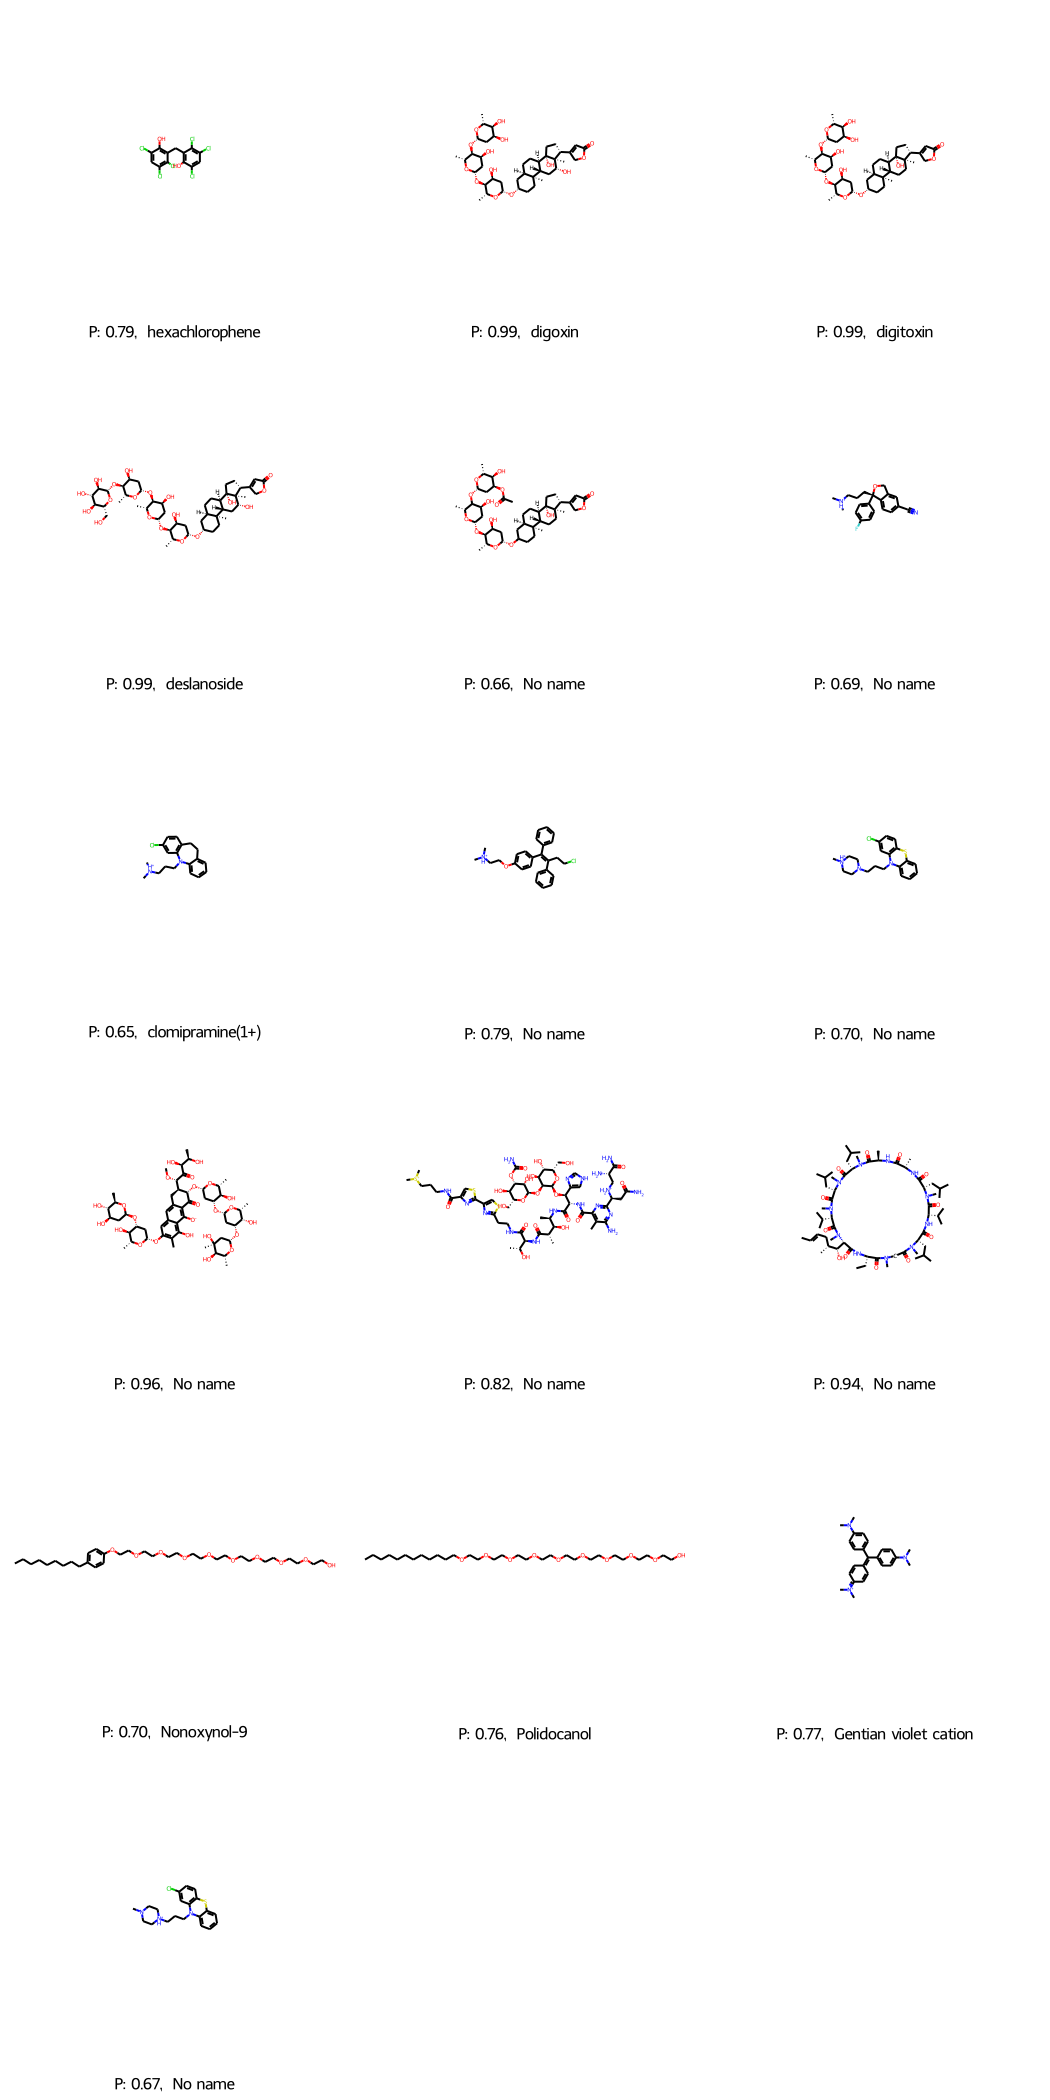

In [ ]:
# Visualize drug candidate molecules
# Print probability score. Print CID and names using PubChem API request

from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import rdkit



size = (240, 240)
structures = []
labels = []

for i, drug in enumerate(drug_candidates):

  smiles = drug['smiles']
  try: name = get_name_from_pubchem_by_smiles(smiles)
  except: name = ["No name"]
  try: CID = get_CID_from_pubchem_by_smiles(smiles)
  except: CID = "No CID"
  mol = Chem.MolFromSmiles(smiles)
  structures.append(mol)
  # fig = Draw.MolToMPL(mol, size=size)
  labels.append(f'P: {drug["activity_score"]:.2f},  {name[0]}')

  print(f'{i} Probability: {drug["activity_score"]:.2f}, CID: {CID},Synonyms: {name}')

labels = [label if label[-1] != 'N' else 'None' for label in labels ]

Draw.MolsToGridImage(structures, legends=labels, molsPerRow=3,subImgSize=(350,350))

In [ ]:
labels

['P: 0.79 hexachlorophene',
 'P: 0.99 digoxin',
 'P: 0.99 digitoxin',
 'P: 0.99 deslanoside',
 'P: 0.66 N',
 'P: 0.69 N',
 'P: 0.65 clomipramine(1+)',
 'P: 0.79 N',
 'P: 0.70 N',
 'P: 0.96 N',
 'P: 0.82 N',
 'P: 0.94 N',
 'P: 0.70 Nonoxynol-9',
 'P: 0.76 Polidocanol',
 'P: 0.77 Gentian violet cation',
 'P: 0.67 N']